### Building a multi-layer perceptron with numpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# build linear layer class
class Linear:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weight = np.random.randn(input_size, output_size)
        self.bias = np.random.randn(output_size)

    def forward(self, input):
        return np.dot(input, self.weight) + self.bias

    def backward(self, input, grad_output):
        grad_input = np.dot(grad_output, self.weight.T)
        grad_weight = np.dot(input.T, grad_output)
        grad_bias = np.sum(grad_output, axis=0)
        return grad_input, grad_weight, grad_bias

In [3]:
# build ReLU activation class
class ReLU:
    def __init__(self):
        pass

    def forward(self, input):
        return np.maximum(0, input)

    def backward(self, input, grad_output):
        relu_grad = input > 0
        return grad_output * relu_grad.astype(float)

In [4]:
# build model class
class Model:
    def __init__(self, input_size, output_size):
        fc1 = Linear(input_size, 32)
        relu1 = ReLU()
        fc2 = Linear(32, 1)
        self.layers = [fc1, relu1, fc2]
        self.layer_outputs = []
        self.train_status = False

    def forward(self, input):
        if self.train_status:
            x = input
            self.layer_outputs = [x]
            for layer in self.layers:
                x = layer.forward(x)
        else:
            x = input
            for layer in self.layers:
                x = layer.forward(x)
        return x

    def backward(self, grad_loss):
        layer_grads = []
        grad_input = grad_loss
        for layer, output in zip(self.layers[::-1], self.layer_outputs[::-1]):
            grad_input, grad_weight, grad_bias = layer.backward(output, grad_input)
            layer_grads.append((grad_weight, grad_bias))
        return layer_grads[::-1]
    
    def train(self):
        self.train_status = True

    def eval(self):
        self.train_status = False
  

In [5]:
class MeanSquaredError:
    def __init__(self):
        pass

    def forward(self, y_pred, y_true):
        return ((y_pred - y_true) ** 2).mean()

    def backward(self, y_pred, y_true):
        return 2 * (y_pred - y_true) / y_true.size

In [6]:
# build stochastic gradient descent optimizer
class SGD:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update_parameters(self, model, gradients):
        for layer, (grad_weight, grad_bias) in zip(model.layers, gradients):
            layer.weight -= self.learning_rate * grad_weight
            layer.bias -= self.learning_rate * grad_bias

### load dataset

In [7]:
housing = fetch_california_housing()
x_train_full, x_test, y_train_full, y_test = train_test_split(housing.data, housing.target.reshape(-1, 1), random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)

In [15]:
# training loop
n_epochs = 25
batch_size = 128
n_iterations = len(x_train) // batch_size
lr = 0.01

model = Model(x_train.shape[1], 1)
criterion = MeanSquaredError()
optimizer = SGD(learning_rate=lr)

train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    epoch_valid_loss = 0.0
    for batch in range(n_iterations):
        # get batch
        start = batch * batch_size
        end = start + batch_size
        x_batch = x_train[start:end]
        y_batch = y_train[start:end]

        # forward pass
        model.train()
        y_pred_batch = model.forward(x_batch)
        loss = criterion.forward(y_pred_batch, y_batch)
        epoch_loss += loss

        # backward pass
        grad_loss  = criterion.backward(y_pred_batch, y_batch)
        gradients = model.backward(grad_loss)

        # Update parameters using SGD
        optimizer.update_parameters(model, gradients)

        # forward pass on validation set
        model.eval()
        y_valid_pred = model.forward(x_valid)
        valid_loss = criterion.forward(y_valid_pred, y_valid)
        epoch_valid_loss += valid_loss
    
    # append average loss for epoch
    epoch_loss /= n_iterations
    epoch_valid_loss /= n_iterations
    train_losses.append(epoch_loss)
    valid_losses.append(epoch_valid_loss)

    # Print average loss every epoch
    print(f'[{epoch+1}/{n_epochs}] Train loss: {epoch_loss:.4f} - Val loss: {epoch_valid_loss:.4f}')


[1/25] Train loss: 75.8720 - Val loss: 179.7754
[2/25] Train loss: 24.4627 - Val loss: 107.8967
[3/25] Train loss: 15.8702 - Val loss: 32.7390
[4/25] Train loss: 16.2630 - Val loss: 106.6319
[5/25] Train loss: 13.3244 - Val loss: 102.1778
[6/25] Train loss: 11.3100 - Val loss: 12.6102
[7/25] Train loss: 11.2229 - Val loss: 14.0804
[8/25] Train loss: 11.0843 - Val loss: 12.9163
[9/25] Train loss: 11.0103 - Val loss: 13.0488
[10/25] Train loss: 10.9499 - Val loss: 12.9651
[11/25] Train loss: 10.9059 - Val loss: 12.9435
[12/25] Train loss: 10.8717 - Val loss: 12.9200
[13/25] Train loss: 10.8434 - Val loss: 12.9045
[14/25] Train loss: 10.8198 - Val loss: 12.8935
[15/25] Train loss: 10.8000 - Val loss: 12.8875
[16/25] Train loss: 10.7834 - Val loss: 12.8841
[17/25] Train loss: 10.7692 - Val loss: 12.8819
[18/25] Train loss: 10.7582 - Val loss: 12.8803
[19/25] Train loss: 10.7496 - Val loss: 12.8786
[20/25] Train loss: 10.7426 - Val loss: 12.8773
[21/25] Train loss: 10.7367 - Val loss: 12.87

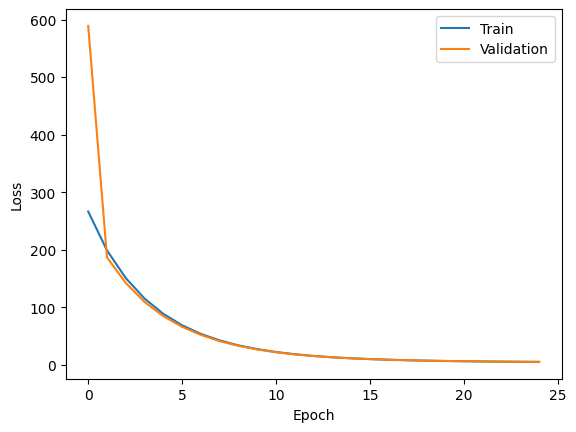

In [13]:
# plot losses
plt.plot(train_losses, label="Train")
plt.plot(valid_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()